# Chapter 4. Molecular Hamiltonians

In this section, we are going to discuss about applying VQE to find the lowest energy on a given complicating moleculars.

This chapter contains several topics

- Born-Oppenheimer approximation
- Fock space
- Fermionic creation and annihilation operators
- Molecular Hamiltonian in the Hatree-Fock orbitals basis
- Basis sets
- Constructing a fermionic Hamiltonian with Qiskit Nature
- Fermion to qubit mappings
- Constructing a qubit Hamiltonian operator with Qiskit Nature

## Installation

This part informs several python packages required for our tutorial.

In [36]:
!pip install numpy      # an open source Python library that is used in almost every field of science and engineering
!pip install qiskit     # an open source SDK for working with quantum computers at the level of pulses, circuits, and application modules
!pip install 'qiskit[visualization]'    # this is for qiskit visualization support
!pip install qiskit.utils               # updated qiskit
!pip install qiskit-nature              # a unique platform that bridges the gap between natural sciences and quantum simulations
!pip install pyscf                      # Python-based Simulations of Chemistry Framework, an open source collection of electronic structure modules powered by Python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user insta

In [37]:
#import packages
import numpy as np

#visualization tools
import matplotlib.pyplot as plt

#qiskit environments and Latex representations of complex array
from qiskit.visualization import array_to_latex, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit import execute, Aer
import qiskit.quantum_info as qi
from qiskit.quantum_info import SparsePauliOp   #updated qiskit
from qiskit.extensions import Initialize
#from qiskit.providers.aer import extensions     #import aer snapshot instructions

#qiskit nature libraries
from qiskit import Aer
#from qiskit_nature.drivers import UnitsType, Molecule

#from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
#from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
#from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
#from qiskit_nature.converters.second_quantization import QubitConverter

# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.second_q.operators import FermionicOp
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html#paulisumop-vs-sparsepauliop
from qiskit_nature import settings

#from qiskit_nature.operators.second_quantization import FermionicOp
#from qiskit_nature.circuit.library.initial_states import HartreeFock
#from qiskit_nature.circuit.library.ansatzes import UCCSD

#Qiskit Nature property framework
#from qiskit_nature.properties import Property, GroupedProperty
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
from qiskit_nature.second_q.operators import ElectronicIntegrals

#math libraries
import cmath
import math

## 4.1 Born-Oppenheimer Approximation

 Since the atomic orbital of an elebron in an atom and the molecular orbital of an electron in a molecule are time-independent stationary states, they can be solved by using time-independent Schrödinger equation: $$ \hat{H} |\Psi \rangle = E | \Psi \rangle $$

 Where $\hat{H}$ is the non-relateve Hamiltonian operator obtained by quantizing the classical energy in Hamiltonian form (first quantization), and it represents the total energy($E$) of all its particles; $N$ electrons and $M$ nuclei.

 Let's define a system containing molecules on the coordinates. The origin of the coordinate system can be placed anywhere in free space. It is shown in the figure below

![Coordinate System with Molecules](./img/coordinates.png)

 The Molecular Hamiltonian in the coordinates is: $$ \hat{H} = -\sum_I \frac{\nabla_{R_I}^{2}}{M_I} -\sum_i \frac{\nabla_{r_i}^{2}}{m_e} -\sum_{I} \sum_{i} \frac{Z_I e^2}{|R_I - r_i|} + \sum_i \sum_{j > i} \frac{e^2}{|r_i - r_j|} + \sum_I \sum_{J > I} \frac{Z_I Z_J e^2}{|R_I - R_J|} $$

 where

- $\nabla_{r_i}^{2}$ and $\nabla_{R_I}^{2}$ are the second derivate operator with respecto to the position coordinates for electrons and nuclei, that is, $\nabla_{R_I}^{2} = \frac{\partial^2}{\partial_{x_I}^{2}} + \frac{\partial^2}{\partial_{y_I}^{2}} + \frac{\partial^2}{\partial_{z_I}^{2}}$ and likewise for the p<sup>th</sup> electrons.
- $r_{ij} = \left|r_i - r_j\right|, r_{iI} = \left|r_i - R_I\right|, R_{IJ} = \left|R_I - R_J\right|$ are the distances between electrons $i$ and $j$, electron $i$ and nucles $I$, and the nuclei $I$ and $J$ determined by the Eulidean norm
- indexes with upper case such as $I, J$ represent nuclei, and indexes with lower case such as $i, j$ represent electrons
- $Z_I$ represents the atomic number of the nuclei

 For clarity, we list the operators of the Molecular Hamiltonian in the table below:

| **Operator**                                            	| **Description**                                                                                                                                           	|
|---------------------------------------------------------	|-----------------------------------------------------------------------------------------------------------------------------------------------------------	|
| $\sum_{I} \frac{\nabla_{r_i}^{2}}{M_I}$                 	| Nuclear ***Kinetic*** Energy Operator                                                                                                                       	|
| $\sum_i \frac{\nabla_{r_i}^{2}}{m_e}$                  	| Electron ***Kinetic*** Energy Operator                                                                                                                      	|
| $\sum_{I} \sum_{i} \frac{Z_I e^2}{\|R_I - r_i\|}$      	| ***Potential*** Energy Operator arising from the interactions between the electrons and nuclei. It is the sum of all electron-nucleus Coulomb interactions. 	|
| $\sum_i \sum_{j > i} \frac{e^2}{\|r_i - r_j\|}$         	| ***Potential*** Energy Operator arising from electron-electron Coulomb repulsions                                                                           	|
| $\sum_I \sum_{J > I} \frac{Z_I Z_J e^2}{\|R_I - R_J\|}$ 	| ***Potential*** Energy Operator arising from nuclear-nuclear repulsion energy operator, the sum of all nucleus-nucleus Coulomb repulsions.                  	|

 In the **Born-Oppenheimer** approximation, we assume that the motions of the nuclie are uncoupled from the motions of the electrons, because the motions of the nuclei and those of the electrons are far different. To simplify, you can think that the position of nuclei are fixed(It is actually false because of the *uncertainty principle*, but it is just for the simplification). In the **Born-Oppenheimer** approximation, you solve for only the electronic equation with the fixed position of the nuclei. So, what we need to consider is just the motions of electrons. Let's define the hamiltonian related to the motions of electrons, which is only the deduction of only-nuclei-related-terms from the **Molecular Hamiltonian**: $$ \hat{H}_{el} = -\sum_{i} \frac{\nabla_{r_i}^{2}}{m_e} - \sum_{I} \sum_{i} \frac{Z_I}{|R_I - r_i|} + \sum_{i} \sum_{j > i} \frac{e^2}{|r_i - r_j|}$$

## 4.2. Fock space

 The electronic wave function $|\Psi\rangle_{elec}$ includes the spatial position for each electron ($r_P = \left\{x_p, y_p, z_p\right\}$) conditioned on the nuclear positions ($R_A = \left\{X_A, Y_A, Z_A\right\}$) and the spin directional coordinates for each electron ($s_p = \left\{s_{x_p}, s_{y_p}, s_{z_p}\right\}$). The electronic wave function must be antisymmetric with respect to the exchange of pair particle labels becuase these particles are fermions.

 The **Fock space** is the Hilbert space in which the *Slater determinant wave functions* , which is antisymmetric with respect to the eschange of two electrons or with respect to the exchange of two spin orbitals, belong. By definition, a Fock space is the sum of a set of Hilbert spaces representing at least 3 important configurations:

- The zero-particle state is interpreted as the **absence** of an electron in an orbital: $|0\rangle$
- One particle states are interpreted as: $|r_p, s_p\rangle$ or $|1\rangle$
- Two particles states are interpreted as: $|r_i, s_i, r_j, s_j \rangle = \frac{1}{\sqrt{2}} \left(|r_j, s_j\rangle \otimes |r_i, s_i \rangle - v|r_i, s_i \rangle \otimes |r_j, s_j \rangle \right)$ or $|11\rangle$

 Yes, this is only a mathematical construction and does not represent a physical reality or a chemical actuality. It can be seem useless, but the Fock space suggests the way to map the electron space of a molecule and the qubit space; but it is not a necessasry mapping. There are more computationally advantageous mapping methods and we will discuss about them later.

## 4.3. Fermionic Creation and Annihilation Operators

 We define a set of fermionic annihilation operators, $\left\{\hat{a}_i \right\}_{i = 0}^{N - 1}$ and creation operators, $\left\{\hat{a}_{i}^{\dagger} \right\}_{j = 0}^{N - 1}$, following anti-commutation relations: $$ \left\{\hat{a}_i, \hat{a}_{j}^{\dagger} \right\} = \hat{a}_{i}^{\dagger}\hat{a}_{j} + \hat{a}_{j}\hat{a}_{i}^{\dagger} = \delta_{ij} = \begin{cases} 0, i \neq j & \\ 1, i = j & \end{cases} \\ \left\{\hat{a}_{i}^{\dagger}, \hat{a}_{j}^{\dagger} \right\} = \left\{\hat{a}_i, \hat{a}_{j} \right\} = 0$$ where $\delta_{ij}$ is the Dirac delta function.

 A **fermionic operator** is a linear combination of products of **creation** and **annihilation operators**.

### 4.3.1. Fermion creation operator

 The fermionic creation operator $\hat{a}_{i}^{\dagger}$ raises by one unit number of particles sitting in the i<sup>th</sup> fermionic orbital: $$ \hat{a}_{i}^{\dagger} |\ldots m_i \ldots \rangle = \left(1 - m_i\right) (-1)^{\sum_{j < i} m_j} |\ldots (m + 1)_i \ldots \rangle $$ where:

- $m_i, (m+1)_i$ are the number of particles sitting in the i<sup>th<\sup> fermionic orbital
- $(1 - m_i)$ is a pre-factor that annihilates the state if we had an electron in the $i^{th}$ fermionic orbital, that is, if $m_i = 1$
- The phase factor $(-1)^{\sum_{j < i} m_j}$ keeps the anti-symmetric properties of the whole superposition of states.

### 4.3.2. Fermion annhilation operator

 The fermionic annhilation operator $\hat{a}_{i}^{\dagger}$ ,on the other hand, lowers by one unit number of particles sitting in the i<sup>th</sup> fermionic orbital: $$ \hat{a}_{i} |\ldots m_i \ldots \rangle = m_i (-1)^{\sum_{j < i} m_j} |\ldots (m - 1)_i \ldots \rangle $$ where:

- $m_i, (m-1)_i$ are the number of particles sitting in the $i^{th}$ fermionic orbital
- $m_i$ is a pre-factor that annihilates the state in the Slater determinant if there is no electron in the $i^{th}$ fermionic orbital, that is, if $m_i = 0$
- The phase factor $(-1)^{\sum_{j < i} m_j}$ keeps the anti-symmetric properties of the whole superposition of states.

## 4.4. Molecular Hamiltonian in the Hatree-Fock orbitals basis

 To map the original **electronic structure Hamiltonian** into the corresponding **qubit Hamiltonian**, we need to work in the second quantization formalism of quantum mechanics, which we have already introduced in the previous section, *Born-Oppenheimer approximation*

 The **Hatree-Fock (HF)** method approximates an N-body problem into N one-body problems where each electron evolves in the **mean field** of other electrons.

 Now, we can rewrite the electronic molecular Hamiltonian ($\hat{H}_{elec}$) as a linear combination of products of creation and annihilation operators: $$ \hat{H}_{elec} = \sum_{i, j} h_{pq} \hat{a}_{p}^{\dagger} \hat{a}_{q} + \frac{1}{2} \sum_{pqrs} h_{pqrs} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}$$

 where $\hat{a}_{p}$ removes an electron from spin-orbital $p$, and $\hat{a}_{q}^{\dagger}$ creates an electron in spin-orbital $q$ The operation $\hat{a}_{p}^{\dagger} \hat{a}_{q}$ is the **excitation operator** which excites an electron from the **occupied spin-orbital** into the **unoccupied orbital**. These mappings are summarized below:

| **Molecular Hamiltonian in the Born-Oppenheimer approximation** | **Linear combination of products of creation and annihilation operators**                                                          | **Description**                                                             |
|-----------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| $\sum_{i} \frac{\nabla_{r_i}^{2}}{m_e}$                         | $\frac{1}{m_e} \sum_{pq} \langle p \mid \nabla_{p}^{2} \mid j \rangle \hat{a}_{p}^{\dagger} \hat{a}_{q}$                           | Electronic kinetic energy operator                                          |
| $\sum_{I} \sum_{i} \frac{Z_I}{\mid R_I - r_i \mid}$             | $\sum_{pq} \langle p \mid \frac{Z_A}{r_{pq}} \mid q \rangle \hat{a}_{p}^{\dagger} \hat{a}_{q}$                                     | Potential energy between the electrons and nuclei.                          |
| $\sum_{i} \sum_{j > i} \frac{e^2}{\mid r_i - r_j \mid}$         | $\sum_{pqrs} \langle pq \mid \frac{1}{r_{pq}} \mid rs \rangle \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}$ | Potential energy operator arising from electron-electron Coulomb repulsions |

 So, we can define $h_{pq}$ and $h_{pqrs}$

 $$ h_{pq} = \langle p \mid \hat{h} \mid q \rangle = \int \phi_{p}^{*} (r) \left(-\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{\mid R_I - r \mid}\right) \phi_q (r) dr $$

 $$ h_{pqrs} = \langle pq \mid \hat{h} \mid rs \rangle = \int \frac{\phi_{p}^{\ast}(r_1) \phi_{q}^{\ast}(r_2) \phi_r(r_2) \phi_s(r_1)}{\mid r_1 - r_2 \mid} dr_1 dr_2 $$

## 4.5. Basis sets

### 4.5.1 Slater Type orbitals

 STO(Slater-Type Orbital)s have the same structure as the atomic orbitals of hydrogen-like systems and thier radial part have the following form: $$ R_l(r) = A(l, \alpha) r^l e^{-\alpha r} $$ where:

- $l$ is the angular momentum quantum with values ranging from 0 to $n - 1$, where $n$ is the principal quantum number
- $r$ is the nuclear distance of the elctron from the atomic nucleus
- $\alpha$ is called the orbital exponent and controls how fast the density of the orbital vanishes as a function of the nuclear distance

 $A(l, \alpha)$ is determined by the following normalization condition: $$\int_{0}^{\infty} \mid R_l(r) \mid^2 r^2 dr = 1 $$

 Noting that: $$\int_{0}^{\infty} x^l e^{-\alpha x} dx = \frac{l!}{\alpha^{l + 1}}$$

 Let's prove the equation above. Let's define $$I(\alpha) = \int_{0}^{\infty} e^{-\alpha x} dx = \frac{1}{\alpha}$$ assuming $I(\alpha)$ is a well-behaved function. Now, we are going to derivate both sides by $\alpha$: $$ \int_{0}^{\infty} (-x)^1 e^{-\alpha x} dx = (-1)(\alpha)^{-2}$$ now derivate once more: $$ \int_{0}^{\infty} (-x)^2 e^{-\alpha x} dx = (-1)^2 \times (2!) \times \alpha^{-3} $$ keep derivate: $$ \int_{0}^{\infty} (-x)^3 e^{-\alpha x} dx = (-1)^3 \times (3!) \times \alpha^{-3} $$ Can you see how it goes? We can figure out what's going to happen when it is derived $l$ times: $$ \int_{0}^{\infty} (-x)^l e^{-\alpha x} dx = (-1)^l \times (l!) \times \alpha^{-(l + 1)} $$ dividing both sides by $(-1)^l$ we get: $$ \int_{0}^{\infty} x^l e^{-\alpha x} dx = \frac{l!}{\alpha^{l + 1}} $$ Be aware that the method we just used only works on well-behave function.

 Back to normalization, we can compute $A(l, \alpha)$: $$ A(l, \alpha) = (2 \alpha)^{l + 1} \sqrt{\frac{2\alpha}{(2l + 2)!}} $$

 For $1s$ orbital, $l = 0$, hence $A(l, \alpha) = 2\alpha^{3/2}$ and the radial part of the Slater orbital is: $$R(r) = 2\alpha^{3/2} e ^{-\alpha r}$$

 Let's plot this function with the following Python code:

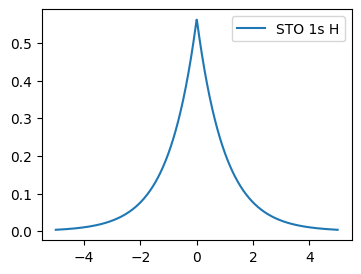

In [38]:
#### Plot 1s STO of H

x = np.linspace(-5,5,num=1000)
# we use absolute value because r is distance between electron and nuclear
r = abs(x)

# it is just experience value approximated when molecule is 1s H
alpha = 1.0

# radial part of the Slater orbital when molecule is 1s H
R = 1/np.sqrt(np.pi)*alpha**(1.5)*np.exp(-alpha*r)

plt.figure(figsize=(4,3))
plt.plot(x,R,label="STO 1s H")
plt.legend()

We plot the antisymmetric spatial wave function for the hydrogen molecule as a linear combination of the preceding radial part of the slater orbital for a hydrogen atom as follows:

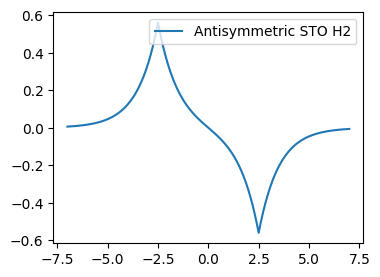

In [39]:
#### Plot 1s STO of H2

x = np.linspace(-7,7,num=1000)

r1 = abs(x+2.5)
r2 = abs(x-2.5)

alpha = 1.0

R = 1/np.sqrt(np.pi)*alpha**(1.5)*np.exp(-alpha*r1)-1/np.sqrt(np.pi)*alpha**(1.5)*np.exp(-alpha*r2)

plt.figure(figsize=(4,3))
plt.plot(x,R,label="Antisymmetric STO H2")
plt.legend()

### 4.5.2. Gaussian-type orbitals

 GTOs have the same angular form as STOs, but their radial function adopts a Gaussian form. By adopting the Gaussian form, they are easy to be computed. GTOs are given: $$ R_l(r) = B(l, \alpha) r^l e^{-\alpha r^2} $$ where:

- $l$ is the angular momentum quantum with values ranging from 0 to $ n - 1$, where n is the principal quantum number.
- $r$ is the nuclear distance of electron from the atomic nucleus
- $\alpha$ is called the orbital exponent and controls how fast the density of the orbital vanishes as a function of the nuclear distance.

 $B(l, \alpha)$ is determined by the following normalization condition: $$ \int_{0}^{\infty} \mid R_l(r) \mid^2 r^2 dr = 1 $$

 In practice, we approximate the radial part of an STO with a linear combination of primitive Gaussian functions, called a contracted Gaussian function. The STO-nG basis sets include one contracted Gaussian function per atomic orbital. $n$ is from 1 to 6, which indicates how many guassian functions are linearly combinated. For example, STO-2G consists of 2 primitive Gaussian functions, and STO-3G consists of 3 of them. In practice, we plot the STO-3G function for the $1s$ orbital of the hydrogen atom.

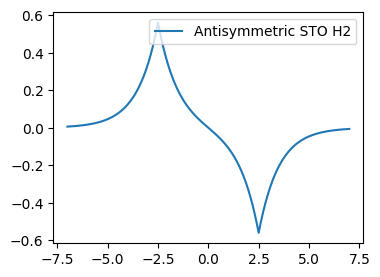

In [40]:
#### Plot 1s GTO of H

x = np.linspace(-7,7,num=1000)

r1 = abs(x+2.5)
r2 = abs(x-2.5)

alpha = 1.0

R = 1/np.sqrt(np.pi)*alpha**(1.5)*np.exp(-alpha*r1)-1/np.sqrt(np.pi)*alpha**(1.5)*np.exp(-alpha*r2)

plt.figure(figsize=(4,3))
plt.plot(x,R,label="Antisymmetric STO H2")
plt.legend()

 We plot the antisymmetric spatial wave function for the hydrogen molecule as a linear combination of the preceding radial part of the slater orbital for a hydrogen atom as follows:

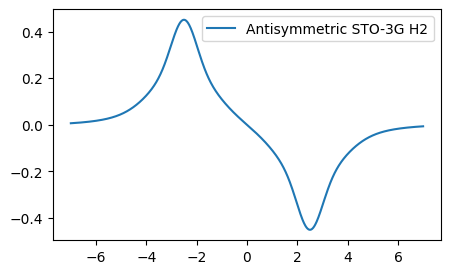

In [41]:
#### Plot 1s STO of H2

x = np.linspace(-7,7,num=1000)
r1 = abs(x+2.5)
r2 = abs(x-2.5)

c = [0.444635,0.535328,0.154329]
alpha = [0.109818,0.405771,2.227660]

psi = 0
for k in range(3):
  psi += c[k]*(2*alpha[k]/np.pi)**0.75 * np.exp(-alpha[k]*r1**2) \
  - c[k]*(2*alpha[k]/np.pi)**0.75 * np.exp(-alpha[k]*r2**2)

plt.figure(figsize=(5,3))
plt.plot(x,psi,label="Antisymmetric STO-3G H2")
plt.legend()

 we plot the STO, STO-2G, and STO-3G in 1s H together to visualize the difference between them

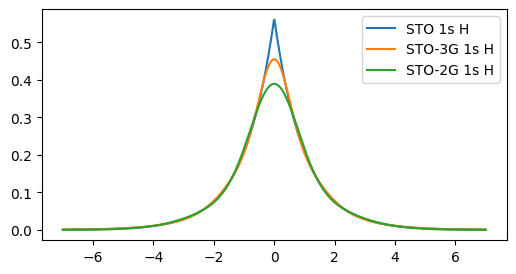

In [42]:
# compare STO and Gaussian

x = np.linspace(-7,7,num=1000)
r = abs(x)

# add STO, 2G, 3G c and aplpha
c_3G = [0.444635,0.535328,0.154329]
c_2G = [0.678914, 0.430129]
alpha_STO = 1
alpha_3G = [0.109818,0.405771,2.227660]
alpha_2G = [0.151623, 0.851819]

plt.figure(figsize=(6,3))

R_STO = 1/np.sqrt(np.pi) * alpha_STO**(1.5)*np.exp(-alpha_STO*r)

psi_3G = 0
psi_2G = 0
for k in range(3):
  gaussian = c_3G[k]*(2*alpha_3G[k]/np.pi)**0.75 * np.exp(-alpha_3G[k]*r**2)
  psi_3G += gaussian
for k in range(2):
  psi_2G += c_2G[k]*(2*alpha_2G[k]/np.pi)**0.75 * np.exp(-alpha_2G[k]*r**2)


plt.plot(x,R_STO,label="STO 1s H")
plt.plot(x,psi_3G,label="STO-3G 1s H")
plt.plot(x,psi_2G, label="STO-2G 1s H")
plt.legend()

## 4.6. Constructing a fermionic Hamiltonian with Qiskit Nature

Qiskit_nature package works with "spin orbital".

then, what is spin orbital?

each molecular orbirals(or spartial orbitals) can have spin-up electron or spin-down elctron. in perspective of molecular orbital, these state is in same states. but in perspective spin orbital, these state are different orbital. easily, for one molecular orbital, we have two spin orbitals. 

now we construct fermionic operator of hydrogen molecule with Qiskit nature

### 4.6.1. Constructing a fermionic Hamiltonian operator of the hydrogen molecule

#### the first things to do for constructing hamiltonian is define molecular geometry of hydrogen molecule with the Qiskit 'Moleculeinfo' class .'Moleculeinfo' class has the following input parameters
- Geometry : a list of atoms name and the cartesian coordinate of each atom (with angstrom units)
    atoms 와, coords(좌표) 는 리스트로 파라미터를 받으며, 두 리스트에서 같은 인덱스 번호끼리 매칭하게 된다. 

    예를 들어 atoms 를 다음과같이 정의한다고 하고, -> ["A","B","C"] # 여기서 A,B,C 는 원자기호이다

    coords 를 다음과 같이 정의한다고 해보자. -> [(0,0,0), (x1,y1,z1), (x2,y2,z2)]

    이렇게 정의하였을때의 기하학적인 구조를 나타내면 아래의 그림과 같다. 
   
   ![Coordinate with molecule](./img/moleculeinfo_coordinate.jpeg)
   
- charge : an integer, the electric charge of the molecule (if the molecule is electrically nature, this value should be 0)

- multiplicity : an integer, the multiplicity $ 2𝑆 + 1 $ of the molecule, where $𝑆$ is the total spin angular momentum, which is determined by the number of unpaired electrons in the molecule, that is, the number of electrons that occupy a molecular orbital singly, not with another electron

    이 개념은 사실 양자역학을 배우지 않았다면 이해하기 힘든 개념일 수 있다. 하지만 간단하게 설명해보겠다. 
    오비탈 개념을 배울때 훈트의 규칙을 들어보았을 것이다. 그 훈트의 규칙 중 "홑전자가 가장 많도록 배치한다. (이때 전자의 방향은 모두 같다)" 라는 고등학교 화학ver 의 설명을 들어보았을 것이다. 

    이거는 사실 순화된 버전이고, 더 엄밀한 문장은 "스핀양자수(S) 가 최대가 되도록 전자는 배치된다" 이다. 

    그럼 스핀 양자수는 무엇인가 하면, 분자의 모드 전자의 스핀의 합이다. 

    우리가 흔히 오비탈이라고 부르는 Spartial orbital에는 전자의 스핀을 고려하여 두개의 전자가 차지 할 수 있다.

    그리고 전자의 스핀양자수는 +1/2 , -1/2 임을 상기하며 생각하면, 두개의 전자로 차있는 오비탈에서는 한 오비탈에서 전자의 스핀의 합이 0이된다. 그리고 당연히 비어있는 오비탈에서는 전자의 스핀이 0이된다. 

    문제가 되는것은 하나의 전자만 가지고 있는 오비탈인데, 그 오비탈에선는 전자의 방향에 따라 +1/2 , - 1/2 가 될 수 있다. 

    두개의 오비탈이 홑전자를 가진다고 가정해보자. 그때, 두 전자의 스핀방향이 다르게(반대로) 배치하면, 그 둘의 스핀각운동량은 상쇄되어 총 스핀양자수는 0이될것이다. 혹은, 두 전자의 스핀방향을 같게하면, 총 스핀양자수는 +1
    또는 -1이 될것이다.
    이때 훈트의 규칙을 생각해보면, 이 스핀양자수가 최대가 되는 방법, 즉 두개의 스핀이 +1/2 로 배치되는 경우가 자연적으로 올바른 바닥상태 라고 할 수 있다. 

    이러한 방식으로, 임의의 분자에 대해 스핀양자수를 계산해볼 수 있고, 이 값의 두배에 1을 더한값이 바로 자유도이다. 

    #### Q. $H_2^+$ 의 자유도(스핀 양자수)를 구해보세요. #나중에 예시코드에 답이 있습니다.



#### 아래는 $H_2$에 대해 분자구조의 기하구조를 모델링 한 예시이다.

In [43]:
H2_atoms = ["H", "H"]
H2_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)]
H2_charge = 0
H2_multiplicity = 1
H2_info_dict={'atoms':H2_atoms, 'coords':H2_coords, 'charge':H2_charge, 'multiplicity':H2_multiplicity}

H2_moleculeinfo = MoleculeInfo(H2_atoms, H2_coords, charge=H2_charge, multiplicity=H2_multiplicity)

이제 basis set을 결정하고, PySCF 클래스를 통해 분자의 기하학적인 구조를 어떤 우리가 풀고자하는 문제상황으로 변환할 수 있다. 

여기서는 분자구조의 헤밀토니안을 만들게 된다.

우선 PySCFDriver.from_molecule 함수를 통해 기하학적인 구조의 Driver 만들게 된다. 이 Driver는 우리가 생각하는 기하학적인 구조를 소프트웨어적인 데이터로 변환하는 과정이다.

In [44]:
H2_driver = PySCFDriver.from_molecule(H2_moleculeinfo, basis="sto3g")

이 드라이버(하드웨어와 소프트웨어의 연결) 을 만들었으니 이제 이 데이터를 계산해야 할것이다. 

이 동네에서 가장 많이 사용하게되는 HF 계산을 실행하는과정이 아래의 코드이고, 이 드라이버를 실행시키면 주어진 H2_moleculeinfo 에 대한 Electrionic Structure Problem 에 대한 클래스를 리턴하게 될것이다. 

Electrionic Structure Problem 얘는 주어진 분자구조에 해당하는 여러 물리량들 뭐, 헤밀토니안, 전자수, 전자의 스핀 등을 계산해두어 저장하는 클래스이고, 

이해하기 쉽게는 주어진 분자구조에 대해 필요한 간단한 계산들을 미리 해둔 정보들을 저장해둔 보관소 라고 생각하면 된다. 

위의 방식으로 이해를 했다면 클래스에서 메소드를 통해 정보를 불러오면 되고, 아래의 방식으로 이해를 했다면, 주어진 코드를 통해 보관소에서 필요한 정보를 꺼내온다고 생각하면 된다. 

In [45]:
H2_problem = H2_driver.run()

드라이버를 런해서 이제 우리가 사전으로 준비하고자 하는것에거의 다 온것이다. 우리가 이 연산에서 가장 필요한것은 "헤밀토니안"이다. 따라서 아래의 코드를 통해 주어진 문제에서 헤밀토니안을 가져오게된다. 

In [46]:
H2_hamiltonian = H2_problem.hamiltonian

거의 다 왔다. 헤밀토니안을 구했는데, 이거를 우리는 스핀오비탈을 basis로 계산할거니까, 이를 스핀오비탈을 basis로 하는 표현으로 바꿔주어야한다. 

스핀오비탈을 basis로 표현하기위해 Fermionic 연산자로 헤밀토니안을 치환(매핑) 해주어야하고, 이렇게 해서 만들어진 헤밀토니안을 2nd quantized Hamiltonian이라고 부른다. 
-> 그래서 우리가 쓸 클래스도 그와 관련된 이름이다.

In [47]:
H2_second_q_op = H2_hamiltonian.second_q_op()
print(H2_second_q_op) #이 셀을 통해 2nd quantized Hamiltonian의 형태를 확인해보세요(+ : Creation , - : annihilation)

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.2563390730032495 * ( +_0 -_0 )
+ -0.4718960072811421 * ( +_1 -_1 )
+ -1.2563390730032495 * ( +_2 -_2 )
+ -0.4718960072811421 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211565 * ( +_0 +_1 -_0 -_1 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211565 * ( +_0 +_3 -_2 -_1 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211572 * ( +_2 +_0 -_1 -_3 )
+ 0.09046

위의 식을 보면 헤밀토니안은 아래의 두가지의 형태를 가지게되는데, 그 각 형태의 의미를 알아보자. 
#### 1) single term

$\hat H_{pq} = h_{pq} a^\dagger_p a_q $--- single term hamiltonian

이 헤밀토니안은 결국, 어떤 분자의 파동함수에 가해지게 될것이고, 기댓값의 측정을 통해 각 상태의 에너지의 기댓값을 구하게 될 것 이다.

그럼 구하는 에너지의 "상태" 가 어떤 물리적인 상태인지를 이해해야 할것이다.

위의 일반화된 single term은 어떤 Reference state를 나타내는 파동함수(정확하게는 모르지만 sto-3g 같은 방식으로 근사한 파동함수)의 기댓값을 측정하게 될 것이다. 그럼 아래의 식으로 나타낼 수 있을것이다. 
$$\langle \Psi \vert \hat H_{pq} \vert \Psi \rangle$$
이는 앞서 정의한대로 표현하면 아래와 같이 표현 할 수 있다. 
$$\langle \Psi \vert  h_{pq}  \hat a^\dagger_p  \hat a_q \vert \Psi \rangle$$

이는 생성/소멸 연산자의 정의대로 생각하게되면, 아래와 같이 Reference State와 한번 여기된 상태의 내적으로 해석 할 수 있다. 
$$ h_{pq} \langle \Psi \vert \Psi^p_q \rangle$$

이는 Slater-cordon rule에 의한 정의에 따르면, (혹은 소멸연산자를 $\langle \Psi \vert$ 에 적용시킨다고 생각하면(이때는 dual vector인 생성 연산자로 바뀌게 된다.)
$$ h_{pq} \langle \Psi^q \vert \Psi^p \rangle$$

와 같이 해석할 수 있다. (이편이 이해하기 더 쉽다.)
스핀오비탈의 각 basis는 orthonormal 하므로, 
$$\delta_{pq}=1 $$
$$\therefore p=q$$

#### 즉, Single term 에서 각 항은 전자가 p(p=q) 오비탈에 있을때의 에너지를 나타내게 된다.
기댓값을 미리 계산해본다면, 계산결과는 아래와 같다. 
$$\langle \Psi \vert \hat H_{pq} \vert \Psi \rangle = \sum_{i=0}^N h_{ii} (where, N :스핀오비탈 수-1)$$

#### 2) Double term 
double term 도 마찬가지 이다. 

기댓값을 측정하게 되면 아래와 같을것이고,
$$\langle \Psi \vert  h_{pqrs}  \hat a^\dagger_p \hat a^\dagger_q \hat a_r  \hat a_s \vert \Psi \rangle$$
마찬가지로 아래와같이 표현할 수 있고
$$h_{pqrs} \langle \Psi   \vert \Psi^{pq}_{sr} \rangle$$
Slater-cordon rule 를 적용하며 아래와같이 표현할 수 있다. 
$$h_{pqrs} \langle \Psi^{sr}   \vert \Psi^{pq} \rangle$$

이때도 마찬가지로 스핀오비탈 basis는 서로 orthonormal 하기 때문에 $p,q,r,s$ 는 아래의 관계식을 만족한다. 
$$\delta_{ps} = 1  , \delta_{qr} = 1 $$
$$\therefore p=s , q=r$$

따라서 $p,q,r,s$ 에 대한 각 항이 나타내는 것은 아래와 같다. 
$$h_{pqrs} \langle \Psi^{qp}   \vert \Psi^{qp} \rangle$$
즉, p오비탈에 있는 전자와 q오비탈에 있는 전자간의 상호작용에 의한 에너지를 의미한다. 

#### 3) 오차
1), 2) 는 사실 이상적인 경우이다. 
spin orbital로 표현된 이상적인 파동함수는 헤밀토니안에 대해 orthonormal 하지만, 

그 파동함수는 계산이 너무 복잡하여, 우리는 Slater orbital로 근사하고, 그 Slater orbital을 STO-3G 등의 방식을 사용해서 한번 더 근사를 하게된다. 

이러한 근사에의해 다른 인덱스에 대해서도 내적값이 0이 되지않고, 값이 존재하게된다.  

H2의 경우를 예로들면, 1) single term에 대해서는 orthonormality 가 유지가 된다. 하지만 2)double term에 대해서는 p=s , q=r 이 아닌경우도 값이 존재하게된다. 

이러한 오차는 분자가 복잡해질수록 커지고, 나중에 보이겠지만, LiH 의 경우에는 1)Single term 에서도 이러한 오차가 발생하게된다. 

헤밀토니안에서 오차로 인해 생기는 항들의 계수는 정상적인 값에 비해 작지만, 양자회로 차원에서 큐비트의 깊이에 미치는 영향은 같기때문에, 회로의 깊이 측면에서 손해이다. 

혹은 아래와같이 행렬의 형태로도 나타 낼 수 있다.

우리가 풀어야 하는건 4개의 스핀오비탈 시스템이고, 각 스핀오비탈은 점유 되어있냐 되어있지 않냐 로 상태를 나눌 수 있고, 그 정보는 양자적이다. 

그래서 이 각각의 스핀오비탈 을 큐비트로 대치시키고, 스핀오비탈로 이루어진 헤밀토니안을 큐비트의 연산인 게이트로 치환시키자는것이 이 분자구조 문제의 핵심 아이디어인데, 

이러한 연산을 그래서 생각해보게되면, 각 상태(혹은 큐비트)는 2x2 행렬이고, 그 상태가 4개 있으므로, 총 상태는 16X16 행렬이 되게 된다.

각 오비탈의 점유상태를 $\vert 0000 \rangle $ , $\vert 0001 \rangle $, ... , $\vert 1111 \rangle $ 등의 Fock basis 로 나타내면 하나의 상태는 16X16의 행렬을 이루게된다. 


마찬가지로, 헤밀토니안을 그러한 행렬의 꼴로 맞춰 표현한것이 아래의 형태이다. 

In [48]:
print(H2_second_q_op.to_matrix())

  (1, 1)	(-0.4718960072811421+0j)
  (2, 2)	(-1.2563390730032495+0j)
  (3, 3)	(-1.2445845498133268+0j)
  (4, 4)	(-0.4718960072811421+0j)
  (5, 5)	(-0.2452182918302661+0j)
  (10, 5)	(0.18093119978423144+0j)
  (6, 6)	(-1.0636533500290954+0j)
  (9, 6)	(0.1809311997842314+0j)
  (7, 7)	(-0.35332510410715434+0j)
  (8, 8)	(-1.2563390730032495+0j)
  (6, 9)	(0.1809311997842314+0j)
  (9, 9)	(-1.0636533500290954+0j)
  (5, 10)	(0.1809311997842313+0j)
  (10, 10)	(-1.8369679912029828+0j)
  (11, 11)	(-1.1606317377577635+0j)
  (12, 12)	(-1.2445845498133268+0j)
  (13, 13)	(-0.35332510410715423+0j)
  (14, 14)	(-1.1606317377577637+0j)
  (15, 15)	(0.21427823841947374+0j)


이제 주어진 전자구조 문제에 대해 입자의 수(전자의 수)를 알아보자. 

방법은 아까와 같이 클래스(보관소) "H2_problem" 에서 메소드를 통해 가져올것이다. 

In [49]:
num_spin_orbitals = H2_problem.num_spin_orbitals
num_particles = H2_problem.num_particles

print("num_particles = ",num_particles,"num_spin_orbitals = ", num_spin_orbitals)


'''
혹은 이런식으로 함수를 정의해서 사용하셔도 좋습니다
def get_particle_number(problem, show=True):
  
  # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.problems.ElectronicStructureProblem.num_spin_orbitals.html
  num_spin_orbitals = problem.num_spin_orbitals
  num_particles = problem.num_particles
  
  if show:
    print("Number of particles: {}".format(num_particles))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
    
  return num_particles, num_spin_orbitals
'''

num_particles =  (1, 1) num_spin_orbitals =  4


'\n혹은 이런식으로 함수를 정의해서 사용하셔도 좋습니다\ndef get_particle_number(problem, show=True):\n  \n  # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.problems.ElectronicStructureProblem.num_spin_orbitals.html\n  num_spin_orbitals = problem.num_spin_orbitals\n  num_particles = problem.num_particles\n  \n  if show:\n    print("Number of particles: {}".format(num_particles))\n    print("Number of spin orbitals: {}".format(num_spin_orbitals))\n    \n  return num_particles, num_spin_orbitals\n'

#### 위의 코드에서 프린트된 결과를 살펴보자. 

스핀오비탈(num_spin_orbitals)이 4개라는거는 이해할 수 있을것 같다. 

수소원자 하나에 스핀오비탈이 두개이고, 우리가 보는 H2 분자는 그 수소원자가 두개있으니까 스핀오비탈이 총 4개인것은 말이 된다. 

근데 앞에 입자수 (num_particles)는 무슨뜻일까.

우리가 앞서 스핀 각 운동량이 +1/2 일때 up-spin 전자라고 하고, -1/2 일때 down-spin 전자라고 한다고 약속을 하였다. 근데 이 Hatree-Fock 계산을 하는 동네에서는 조금 더 편하게 부르기 위해, up-spin 을 $\alpha$ 전자, down-spin 을 $\beta$ 전자 라고 부른다. 그리고, 저 (num_particles)은 (H2_problem.num_alpha, H2_problem.num_beta) 의 형태이다. 즉, 저 튜플이 의미하는 것은 ( 업스핀 전자수, 다운스핀 전자수) 인것이다. 

아래의 세가지를 프린트해서 직접 확인해보는것을 추천한다. 
- H2_problem.num_alpha
- H2_problem.num_beta
- H2_problem.num_particles

이제 필요한 계산을 마쳤으니 에너지를 계산해볼까? 

이제 VQE의 시작인가 하겠지만, 사실 아까 H2_problem 이 우리가 필요한 물리량들을 다 계산해둔 보관소라고 했다. 

그니까 에너지도 사실 계산되어있다. 

근데 우리가 해야할거는 이후 진행할 우리의 VQE 알고리즘이 얼마나 실제 값과 비슷한지 알아야 나중에 더 어려운 분자에서 레퍼런스 에너지를 구할 수 없는 상황에서도, 우리의 VQE 계산값이 맞다는 근거를 가지고 앞으로 나아 갈 수 있을것이다. 

그래서 전반적인 지금의 목적은 VQE의 계산값과 레퍼런스 에너지를 비교해보는것이다. 

일단 레퍼런스 에너지를 H2_problem 으로부터 계산해두고, 저장해두자.

In [50]:
H2_reference_energy = H2_problem.reference_energy
print(H2_reference_energy)

-1.1169989967540035


### 4.6.2. Constructing a fermionic Hamiltonian operator of the lithium hydride molecule


지금까지 H2에 대해서 헤밀토니안을 구성하는 방법을 배웠다. 이제는 LiH 분자에 대해서 헤밀토니안을 구해볼 것이다. 

위 방법을 이해했다면, 아래의 계산도 쉽게 할 수 있을것이다. 

In [51]:
#1 마찬가지로 분자의 구조를 저장한다.

LiH_atoms = ["Li", "H"]
LiH_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 1.5474)]
LiH_charge = 0
LiH_multiplicity = 1
LiH_atom_pair=(1,0)
LiH_info_dict={'atoms':LiH_atoms, 'coords':LiH_coords, 'charge':LiH_charge, 'multiplicity':LiH_multiplicity, 'atom_pair':LiH_atom_pair}

LiH_moleculeinfo = MoleculeInfo(LiH_atoms, LiH_coords, charge=LiH_charge, multiplicity=LiH_multiplicity)

In [52]:
#2 분자의 구조를 통해 드라이버를 만들고
#  드라이버를 실행하여 Electronic Structure Problem 클래스를 만든다.
LiH_driver = PySCFDriver.from_molecule(LiH_moleculeinfo, basis="sto3g")
LiH_problem = LiH_driver.run()
print (LiH_problem.num_spin_orbitals, LiH_problem.num_particles)

12 (2, 2)


이제 LiH 에서는 FreezeCoreTransformer를 해줄것이다.

이거는 결합에 참여하지 않는 오비탈을 제외하는 과정이다. 

LiH의 경우로 설명하게 되면 Li의 경우 (1s 2s)로 총 4개의 spartial orbital을 가질것이고, 수소의 경우 (1s) 로 총 2개의 spartial orbital을 가질것이다.
따라서 총 12개의 스핀오비탈이 있을것이고, 12개가 바로 위의 코드에 나타나있다. 
근데 이제 여기서 분자결합을 생각하고, 결합에 참여하지 않는 오비탈을 빼보게되면, 결국 리튬의 최외곽 전자 1개와 수소의 최외곽 전자 1개가 결합을 하게되는 H2의 경우와 같게된다. 
따라서 FreezeCoreTransformer를 가하게되면, 아래와같이 4개의 스핀오비탈만이 나오게된다. 

In [53]:
transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])
LiH_problem = transformer.transform(LiH_problem)
print (LiH_problem.num_spin_orbitals, LiH_problem.num_particles)

6 (1, 1)


In [54]:
LiH_fermionic_hamiltonian = LiH_problem.hamiltonian
LiH_second_q_op = LiH_fermionic_hamiltonian.second_q_op()

In [55]:
print("Lithium hydride molecule, basis: sto3g, Hartree-Fock calculation")
print("Parameters freeze_core=True")
LiH_particle_number =LiH_problem.num_particles

Lithium hydride molecule, basis: sto3g, Hartree-Fock calculation
Parameters freeze_core=True


In [56]:
LiH_reference_energy = LiH_problem.reference_energy
print(LiH_reference_energy)

-7.863113882796406


In [57]:
# We print the first 20 terms of the fermionic Hamiltonian operator of the molecule
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
print("\n".join(str(LiH_second_q_op ).splitlines()[:22] + ["..."]))

Fermionic Operator
number spin orbitals=6, number terms=342
  -0.7806641137752635 * ( +_0 -_0 )
+ 0.04770212743625808 * ( +_0 -_1 )
+ -0.12958118796013018 * ( +_0 -_2 )
+ 0.04770212743625828 * ( +_1 -_0 )
+ -0.3590972946155381 * ( +_1 -_1 )
+ 0.06823802873504789 * ( +_1 -_2 )
+ -0.12958118796013013 * ( +_2 -_0 )
+ 0.06823802873504793 * ( +_2 -_1 )
+ -0.22617114856208465 * ( +_2 -_2 )
+ -0.7806641137752635 * ( +_3 -_3 )
+ 0.04770212743625808 * ( +_3 -_4 )
+ -0.12958118796013018 * ( +_3 -_5 )
+ 0.04770212743625828 * ( +_4 -_3 )
+ -0.3590972946155381 * ( +_4 -_4 )
+ 0.06823802873504789 * ( +_4 -_5 )
+ -0.12958118796013013 * ( +_5 -_3 )
+ 0.06823802873504793 * ( +_5 -_4 )
+ -0.22617114856208465 * ( +_5 -_5 )
+ 0.24548488034876564 * ( +_0 +_0 -_0 -_0 )
+ -0.02385105980699155 * ( +_0 +_0 -_0 -_1 )
...


In [58]:
print(LiH_second_q_op.to_matrix())

  (1, 1)	(-0.22617114856208465+0j)
  (2, 1)	(0.06823802873504789+0j)
  (4, 1)	(-0.12958118796013018+0j)
  (1, 2)	(0.06823802873504793+0j)
  (2, 2)	(-0.3590972946155381+0j)
  (4, 2)	(0.04770212743625808+0j)
  (3, 3)	(-0.3698582654236022+0j)
  (5, 3)	(0.03641071436289452+0j)
  (6, 3)	(0.14941663381648998+0j)
  (1, 4)	(-0.12958118796013013+0j)
  (2, 4)	(0.04770212743625828+0j)
  (4, 4)	(-0.7806641137752635+0j)
  (3, 5)	(0.03641071436289481+0j)
  (5, 5)	(-0.6744095751420309+0j)
  (6, 5)	(0.051117330409696654+0j)
  (3, 6)	(0.14941663381648992+0j)
  (5, 6)	(0.05111733040969673+0j)
  (6, 6)	(-0.9271642111544168+0j)
  (7, 7)	(-0.6054994947671638+0j)
  (8, 8)	(-0.22617114856208465+0j)
  (16, 8)	(0.06823802873504789+0j)
  (32, 8)	(-0.12958118796013018+0j)
  (9, 9)	(0.003031109256421194+0j)
  (10, 9)	(0.024426932936970173+0j)
  (12, 9)	(0.007977803851761278+0j)
  :	:
  (53, 54)	(0.03601000179255513+0j)
  (54, 54)	(-0.5746431507664239+0j)
  (31, 55)	(-0.1067745448649335+0j)
  (47, 55)	(-0.00780109

## 4.7. Fermion to qubit mapping

N개의 페르미온으로 이루어진 시스템을 고려할때, 각 페르미온들을 0부터 N-1 까지 인덱스를 줄것이다. 

여기서 우리가 해야할것은, 각 페르미온 상태를 큐비트 상태로 매핑해야하고, 또한 각 페르미온 연산자를 멀티 큐비트 연산자로 매핑하여야한다(생성/소멸 연산자를 큐비트 게이트로 매핑)

이 동네에서 가장 많이 쓰이는것은 Jordan-Wigner 과 Bravyi-Kitaev 변환이 가장 많이 쓰이고 이는 전자의 수와 동일한 큐비트개수만 필요하다는 장점이 있다. 

### 4.7.1. Qubit creation and annihilation operators

그럼 큐비트적으로 생성과 소멸 연산자를 표현하는 방법을 배워보자. 
생성과 소멸이라는 것이 뭘까를 생각해보면, 

$\vert 0 \rangle $ 상태를 $\vert 1 \rangle $ 상태로 만드는것이 생성이고, 

$\vert 1 \rangle $ 상태를 $\vert 0 \rangle $ 상태로 만드는것이 소멸이다. 

그리고 앞서 정의한대로 $\vert 0 \rangle $ 상태에 소멸연산자를 가하면 0이될것이고,

그리고 $\vert 1 \rangle $ 상태에 생성연산자를 가하면 0이될것이다.

우리가 정의하기를 $\vert 0 \rangle = {1 \choose 0} $ , $\vert 1 \rangle = {0 \choose 1} $ 라고 정의하였으므로, 행렬적인 연산으로 저 두상태를 바꾸는 식으로 구성을 할 수 있을것 같다. 

그렇게  약속한것이 아래의 그림이다. 

![Qubit_creation:annihilation](./img/Qubit_creation:annihilation.png)

이처럼 정의하게되면 아래와 같이 우리가 앞서 정의한 정의를 만족한다. (아래 계산은 직접한번 해보는것이 좋다.)

$\sigma^+\vert 0 \rangle  = \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 1 \\  0 \end{pmatrix} = \begin{pmatrix} 0 \\  1 \end{pmatrix} = \vert 1 \rangle  $

$\sigma^+\vert 1 \rangle  = \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} 0 \\  1 \end{pmatrix} = 0 $

$\sigma^-\vert 0 \rangle  = \begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix} \begin{pmatrix} 1 \\  0 \end{pmatrix} = 0 $

$\sigma^-\vert 1 \rangle  = \begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix} \begin{pmatrix} 0 \\  1 \end{pmatrix} = \begin{pmatrix} 1 \\  0 \end{pmatrix} = \vert 0 \rangle  $

그리고, 이러한 큐비트 생성/소멸 연산자는 아래의 anti-commutation Relation을 만족한다. 

$[\sigma^+,\sigma^-]= \mathbb{I} $


### 4.7.2. Jordan-Wigner transformation

Jordan-Wigner transformation 은 각 스핀오비탈의 점유상태를 각 큐비트에 저장하게 된다. 

그걸 어떻게 하나면, 페르미온 생성/소멸 연산자를 파울리 연산자의 텐서곱으로 표현한다. 

$\sigma^+_k , \sigma^-_k $ 의 연산자는 k번째 오비탈에 대응되는 큐비트에 점유상태를 바꾸게된다. 

$\sigma_z$ 의 텐서곱으로 이루어진 파울리 연산자 $\sigma_z^{\otimes k}$ 는 페르미온 연산자가 만족해야 할 anti-commutation relation을 만족해야하는데, 그러기위해 연산자를 가할 k번째 전에 오비탈에 대해 +,- 의 Parity를 추가하여, 그 anti-Symmetry 를 만족시킨다.


위  표에서는 큐비트의 인덱스가 안달려 있어서 헷갈리게 표현이 되어있다. 따라서 해설을 달자면

$\hat a_k^\dagger$ 에 대해 생각을 해보자. 

이는 k 번째 "오비탈"에 생성 연산자, 즉 전자 하나를 추가하는 연산이다. 

우리는 이거를 Transform을 통해 큐비트와 관련된 연산으로 바꾸고 싶다. 즉 여기서는 각각의 오비탈을 큐비트로 매핑하게된다. 

그래서 마찬가지로 k 번째 큐비트에 해당하는 연산은 큐비트 버전의 생성 연산자 $\sigma_k$ 가 걸리게 된다. 

여기서 이제 아까 말했던 parity를 추가할것이다. 

k번째 큐비트가 있으면, 그 전의 k-1번째, k-2번째, ..., 0번째 큐비트가 있을것이다. 그 큐비트에는 모두 Z 연산자를 가한다. 이는 앞서도 설명하였지만, 생성 연산자가 가지고 있어야할 반대칭을 만족하기 위한 항 이다. 

그리고 k번째 큐비트 이후의 큐비트, 즉 k+1, k+2, ... N(여기서 N은 총 큐비트 개수, 예를들어 4큐비트 시스템에서 N=4)에는 단위행렬, 즉 아무 연산도 안 하게된다. 

이 풀이를 그대로 식으로 옮기게되면, 아래와 같다. 

$$ Z_0 \otimes Z_1 \otimes ... \otimes Z_{k-1} \otimes \sigma^+_k \otimes \mathbb{I}_{k+1} \otimes \mathbb{I}_{k+2} \otimes ...\otimes \mathbb{I}_{N}$$

여기서 \sigma^+_k 를 파울리연산자로 표현하게되면, $1/2 (X-iY)$ 이므로 파울리 연산자의 텐서곱으로 표현하려고했던 초기 목적대로 표현하게 되면 아래와 같다. 

$$1/2  Z_0 \otimes Z_1 \otimes ... \otimes Z_{k-1} \otimes (X_k -iY_k) \otimes \mathbb{I}_{k+1} \otimes \mathbb{I}_{k+2} \otimes ...\otimes \mathbb{I}_{N}$$

이 결과를 보게되면, 하나의 Fermionic 연산자를 매핑할때, 큐비트의 개수만큼의 항이 필요하게된다. 이는 만약 n개의 연산자가 있다면 Nn개의 파울리 연산자가 필요할것이다. 

따라서 JW 변환은, 큐비트의 개수에 대해 선형적이다 $(=O (N))$

그럼 이제 이러한 변환을 직접 코드를 통해 확인해보자.

In [59]:
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html#paulisumop-vs-sparsepauliop
settings.use_pauli_sum_op = False

# https://qiskit.org/documentation/nature/locale/bn_BN/stubs/qiskit_nature.second_q.operators.FermionicOp.html
# A FermionicOp is initialized with a dictionary, mapping terms to their respective coefficients

def label_to_qubit(label, mapper):
    f_op = FermionicOp(label)
    qubit_op = mapper.map(f_op)
    return qubit_op
#fermionic_label = ["+_0", "+_1", "+_2", "+_3", "+_4"]

for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, {"+_4":1.0}):
  qubit_op = label_to_qubit(k, JordanWignerMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZZ', 'YZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZZZ', 'YZZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_4': 1.0}:
 SparsePauliOp(['XZZZZ', 'YZZZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])



위에서 수식으로 보았던것 처럼, 예를들어 $\hat a ^\dagger_3$ 이 JW변환된 결과를 보면, 

0,1,2 번째 큐비트에는 Z연산자가 가해지고, 3번째 큐비트 에는 $1/2 (X-iY)$ 가 가해지는것을 볼 수 있다. 

### 4.7.3. Parity transformation

Parity 변환은 JW변환과 대응되는 다른 변환이다. 

Parity 변환은 Parity 연산자에는 낮은 가중치를 부여하고, 점유상태를 나타내는 연산자에는 높은 가중치를 부여한다. 

수학적이 매핑 방법은 아래의 그림과 같다. 

![Coordinate System with Molecules](./img/Parity.png)

마찬가지로 항에 대해 설명을 하자면, 

JW 와 마찬가지로 k 번째 큐비트에 해당하는 연산은 큐비트 버전의 생성 연산자 $\sigma_k (=X_k\pm iY_k) $가 걸리게 된다.

하지만 Parity를 추가하는 부분이 반대이다. 

k보다 작은 인덱스에 대해서는 X오퍼레이터에서는 k-1번째에만 Z오퍼레이터가 붙고, k-2,k-3,...,0 번째 큐비트는 I 연산자가 가해진다, 
                      Y오퍼레이터 부분에는 k-1, k-2,..., 0 번째 큐비트 모두 I 연산자가 가해진다, 

k보다 큰 인덱스에 대해서는 X오퍼레이터가 가해지게된다.즉, k번째 오비탈에 생성이 가해지는 연산자의 경우 아래와같이 표현 할 수 있다. 

$$ 1/2  \mathbb{I}_{0} \otimes \mathbb{I}_{1} \otimes ...\otimes \mathbb{I}_{k-2} (Z_{k-1} X_k -iI_{k-1}Y_k)\otimes X_{k+1} \otimes X_{k+2} \otimes ... \otimes X_{N}$$

즉 여기서는 잘 알려져있는 Symmetry를 도입하여, 두개의 큐비트로 문제를 줄였다. 
아래가 예시코드이다. 

In [60]:
for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, {"+_4":1.0}):
  qubit_op = label_to_qubit(k, ParityMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZI', 'YII'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZII', 'YIII'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_4': 1.0}:
 SparsePauliOp(['XZIII', 'YIIII'],
              coeffs=[0.5+0.j , 0. -0.5j])



### 4.7.4. Bravyi-Kitaev Transformation transformation

Bravyi-Kitaev(BK) 변환은 시스템의 크기(N)이 2의 정수 지수꼴일때만 사용할 수 있다. 
$$N=2^m (m : 어떤 자연수)$$
이때 BK-basis 와 변환에서는 하나의 Fermionic연산자(생성/소멸연산자) 를 큐비트 연산자로 매핑할때 $log(N)$ 개의 큐비트연산자가 필요하다. (즉, 앞선 방법보다 적다)

BK변환은 Occupation Number basis(생성/소멸 연산자를 통해 표현하던 기존의 표현방식)을 BK-basis로 치환하게된다. 
$$\vert f_0...f_{N-1}\rangle (Occupation Number basis)-> \vert b_0...b_{N-1}\rangle (BK-basis)$$
$$b_n 은 행렬 B_N 의 성분이다$$
$$행렬 B_N 은 recursion 관계식(점화식) 으로 정의된다.$$

![Bk Reculsive Relation](./img/Bk-Relation.png)

이에대한 예시가 바로 아래의 m= 1, 2 인 경우이다.( $N=2^m$ 이므로 N = 2, 4)

![BK Relation Example](./img/BK-Example.png)

임의의 m (2^m 개의 시스템에 적용할 수 있음) 에대한 BK-basis 행렬을 구하는 코드는 아래와 같다. 

In [61]:
def BK(m):
  I = [[1, 0], [0, 1]]
  d = {}
  d[0] = [1]
  for k in range(0, m):
    B = np.kron(I,d[k])
    for l in range(2**k, 2**(k+1)):
      B[0,l] = 1
    d[k+1] = B
  return d

d = BK(3)
for k, v in d.items():
  s = "B_{"+str(2**k)+"} = "
  display(array_to_latex(v, prefix=s, precision = 0))
  print(" ")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

여기서 새로운 노테이션에 대한 정의를 한다. 
- Parity set $P(k)$ : k보다 작은 인덱스의 오비탈에 대한 Parity 를 인코딩하여 Global Phase 를 주게되는 큐비트의 집합
- Update set $U(k)$ : k번째의 인덱스의 오비탈의 점유상태가 바뀔때 Flip 되는 큐비트의 집합
- flip set $F(k)$ : k번째 큐비트 가 k번째 오비탈과 같은 parity 를 가지는지, 다른 parity를 가지는지 결정하는 큐비트의 집합. (이는 홀수인 k일때 필요하다.)

이 세개의 집합은 앞서 정의한 $B_N$ 으로 부터 얻어 질 수 있다. 

또한, remainder set R(k) = F(k)/P(k) 로 부터 얻어지게된다.
이러한 원리로 매핑을 하게되면 아래와 같다. 

![BK-Transformation](./img/BK-Transformation.png)


방식은 앞선 Parity 변환과 유사하지만, Basis가 Bk-basis로 표현된다. 
이를 코드로 확인해보면 아래와 같다. 

In [62]:
for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, {"+_4":1.0}):
  qubit_op = label_to_qubit(k, BravyiKitaevMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZI', 'YZI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZZI', 'YIII'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_4': 1.0}:
 SparsePauliOp(['XZIII', 'YZIII'],
              coeffs=[0.5+0.j , 0. -0.5j])



## 4.8. Constructing a qubit Hamiltonian operator with Qiskit Nature

이 챕터에서는 이제 앞서 배운 모든 내용을 종합하여, 큐비트 버전의 헤밀토니안을 만들어볼것이다. 

코드상으로는 4.6에서 구성한 Ferimionic 버전의 헤밀토니안을 4.7의 매핑을 이용하여 큐비트의 헤밀토니안으로 치환하는 과정을 코드로 보일것이다. 
그 치환하는 과정을 하나의 함수로써 지정해둘것이고, 그 함수는 아래와 같다. 

fermion_to_qubit(problem, second_q_op, mapper_name, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True)

각 파라미터의 역할은 아래와 같다. 
- problem : 앞서 4.6장에서 Driver 를 통해 정의한 문제상황에 대한 클래스이다. 이를 굳이 파라미터로 받는 이유는, ParityMapper에서 num_paticles를 얻기위해 메소드를 받아서 사용하기 위함과, z2symmetry_reduction 을 적용할때 클래스로부터 get_tapered_mapper라는 메소드를 받아서 사용하기 위해 파라미터로 받는다. 
- second_q_op : 우리가 매핑하고자하는 Fermionic 연산자로 구성된 헤밀토니안이다. 
- mapper_name : 사용하고자하는 매퍼이다(JW, Parity, BK)
- truncate : 결과물을 어디까지 표현할 것인지를 나타낸다. 
- two_qubit_reduction : two_qubit_reduction 이 가능할때 이를 수행할지, 말지를 결정한다. 
- z2symmetry_reduction : Fermionic 연산자를 큐비트연산자로 바꾸었을때, 그 연산자 내에서 대칭성 혹은 성질들을 이용해 큐비트 연산자 수를 줄일것인지 선택한다. 
- show : 결과물과 직접적인 연관은 없지만, 그 결과인 큐비트 연산자와, 어떤 매퍼를 사용했는지를 print 할것이냐 , 말것이냐를 결정한다. 

In [63]:
def fermion_to_qubit(problem, second_q_op, mapper_name, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
# https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html#qubitconverter
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html
  
  if show:
    print("Qubit Hamiltonian operator")
    print("{} transformation ". format(mapper_name))
  if mapper_name == "Jordan-Wigner":
    mapper = JordanWignerMapper()
  if mapper_name == "Parity":
    mapper = ParityMapper(num_particles=problem.num_particles)
  if mapper_name == "Bravyi-Kitaev":
    mapper = BravyiKitaevMapper()
  
  qubit_op = mapper.map(second_q_op)
  
  if z2symmetry_reduction != None:
    tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(second_q_op)
    
  n_items = len(qubit_op)
  if show:
    print("Number of items in the Pauli list:", n_items)
    if n_items <= truncate:
      print(qubit_op)
    else:
      print(qubit_op[0:truncate])
  return qubit_op, mapper

### 4.8.1. Constructing a qubit Hamiltonian operator of the hydrogen molecule

이제 앞서 구성한 수소분자 $H_2$ 에 대한 Fermionic operator 를 큐비트 연산자로 치환해볼것이다. 

#### 4.8.1.1 H2 - JW 

In [64]:
settings.use_pauli_sum_op = True
print("Hydrogen molecule")
H2_qubit_op, qubit_converter = fermion_to_qubit(H2_problem, H2_second_q_op, "Jordan-Wigner", two_qubit_reduction=True)

Hydrogen molecule
Qubit Hamiltonian operator
Jordan-Wigner transformation 
Number of items in the Pauli list: 15
-0.8105479805373275 * IIII
+ 0.17218393261915538 * IIIZ
- 0.22575349222402386 * IIZI
+ 0.17218393261915538 * IZII
- 0.2257534922240238 * ZIII
+ 0.12091263261776626 * IIZZ
+ 0.16892753870087907 * IZIZ
+ 0.04523279994605785 * YYYY
+ 0.04523279994605785 * XXYY
+ 0.04523279994605785 * YYXX
+ 0.04523279994605785 * XXXX
+ 0.1661454325638241 * ZIIZ
+ 0.1661454325638241 * IZZI
+ 0.17464343068300453 * ZIZI
+ 0.12091263261776626 * ZZII


#### 4.8.1.2 H2 - parity

In [65]:
print("Hydrogen molecule")
H2_qubit_op, qubit_converter = fermion_to_qubit(H2_problem, H2_second_q_op, "Parity", two_qubit_reduction=True)

Hydrogen molecule
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 5
-1.0523732457728596 * II
+ 0.39793742484317907 * IZ
- 0.39793742484317907 * ZI
- 0.01128010425623538 * ZZ
+ 0.1809311997842313 * XX


#### 4.8.1.3 H2 - Bravyi-Kitaev

In [66]:
print("Hydrogen molecule")
H2_qubit_op, qubit_converter = fermion_to_qubit(H2_problem, H2_second_q_op, "Bravyi-Kitaev", two_qubit_reduction=True)

Hydrogen molecule
Qubit Hamiltonian operator
Bravyi-Kitaev transformation 
Number of items in the Pauli list: 15
-0.8105479805373275 * IIII
+ 0.17218393261915538 * IIIZ
- 0.22575349222402386 * IIZZ
+ 0.17218393261915538 * IZII
- 0.2257534922240238 * ZZZI
+ 0.12091263261776626 * IIZI
+ 0.16892753870087907 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
+ 0.1661454325638241 * ZZZZ
+ 0.1661454325638241 * IZZZ
+ 0.17464343068300453 * ZZIZ
+ 0.12091263261776626 * ZIZI


### 4.8.2. Constructing a qubit Hamiltonian operator of the lithium hydride molecule

여기서는 Jordan-Wigner를 사용할것이고, 큐비트 헤밀토니안에서 두개의 큐비트를 지우기 위해 two_qubit_reduction=True 로 설정할것이다. 

그리고 z2symmetry_reduction="auto" 로 설정하고, 첫 20개의 큐비트 연산자만 프린트해보자. 

In [67]:
print("Lithium hydride molecule")
print("Using the ParityMapper with two_qubit_reduction=True to eliminate two qubits")
print("Setting z2symmetry_reduction=\"auto\"")
LiH_qubit_op, qubit_converter = fermion_to_qubit(LiH_problem, LiH_second_q_op, "Jordan-Wigner", two_qubit_reduction=True, z2symmetry_reduction="auto")

Lithium hydride molecule
Using the ParityMapper with two_qubit_reduction=True to eliminate two qubits
Setting z2symmetry_reduction="auto"
Qubit Hamiltonian operator
Jordan-Wigner transformation 


Number of items in the Pauli list: 100
-0.20316606150092517 * IIII
+ 0.09275994938683754 * IIZZ
- 0.0029411421560544522 * IIZX
- 0.0029411421560544522 * IIIX
+ 0.0007427993097092129 * IIXI
+ 0.0007427993097092129 * IIXZ
- 0.21188984283540052 * IIIZ
+ 0.019389408263719064 * IIYY
+ 0.019389408263719064 * IIXX
- 0.3652586902997109 * IIZI
+ 0.09275994938683746 * ZZII
- 0.002941142156054466 * ZXII
- 0.002941142156054466 * IXII
+ 0.0007427993097093672 * XIII
+ 0.0007427993097093672 * XZII
- 0.21188984283540052 * IZII
+ 0.01938940826371913 * YYII
+ 0.01938940826371913 * XXII
- 0.36525869029971103 * ZIII
+ 0.12274244017438277 * ZZZZ


나머지 분자, 변환에서의 경우에도 직접 해보면서 차이를 관찰해보세요.

# Appendix A: Gaussian product theorem

#### This section is for the section B. If you are not interested in complicated computations, skip to Appendix B.


From now on, we are going to compute lots of integrals and products of gaussian-like functions. This section deals about the computations that will ease those computations.

Gaussian product theorem starts from a gaussian-like function on cartesian coordinates:

$$ G(x_A, y_A, z_A, \alpha_1) = x_A^l y_A^m z_A^n e^{-\alpha_1 r_A^2}, where r_A^2 = x_A^2 + y_A^2 + z_A^2, x_A = x - A_x, y_A = y - A_y, z_A = z - A_z, A = (A_x, A_y, A_z) $$

The equation above is a gaussian-like function which is centered on A. Now let's compute the product of 2 Gaussian-like functions:

$$ G_1 G_2 = x_A^{l_1} y_A^{m_1} z_A^{n_1} x_B^{l_2} y_B^{m_2} z_B^{n_2} e^{-\alpha_1 r_A^2} e^{-\alpha_2 r_B^2} $$

we are going to focus on exponential terms first. exponential terms are:

$$ e^{-\alpha_1 r_A^2} e^{-\alpha_2 r_B^2} $$

2 exponential terms are creepy as hell. Let's combine them into 1 exponential term.

$$ e^{-\alpha_1 r_A^2} e^{-\alpha_2 r_B^2} = K e^{-\gamma r_P^2}$$

$K, \gamma$ is a constant and $P$ is a linear combination of two point vector A and B. We can compute $K, \gamma, P$ by extracting the degrees of exponential terms:

$$\mathbf{exp}\left[-\alpha_1\left(r - A\right)^2 - \alpha_2\left(r - B\right)^2\right] = K\mathbf{exp}\left[-\gamma\left(r - P\right)^2\right]$$

$$\mathbf{exp}\left[-\left(\alpha_1 + \alpha_2\right)r \cdot r + 2\left(\alpha_1 A + \alpha_2 B\right) \cdot r - \left(\alpha_1 A \cdot A + \alpha_2 B \cdot B\right)\right] = K\mathbf{exp}\left[-\gamma r \cdot r + 2\gamma\ r \cdot P - \gamma P \cdot P\right]$$

where, $r$ is a vector, $r = (x, y, z) $. We can figure out $K, P, \gamma$ by comparing both sides:

\begin{align}
    \gamma &= \alpha_1 + \alpha_2\\
    P &= \frac{\alpha_1A + \alpha_2B}{\gamma} \\
    K \cdot \mathbf{exp}\left[-\gamma P \cdot P \right] &= \mathbf{exp}\left[-\alpha_1 A \cdot A - \alpha_2 B \cdot B \right] 
\end{align}

$$\therefore \gamma = \alpha_1 + \alpha_2, P = \frac{\alpha_1 A + \alpha_2 B}{\gamma}, K = e^{-\alpha_1 A \cdot A - \alpha_2 B \cdot B +\gamma P \cdot P}$$

Moreover, we can simplify K. Let's compute $\gamma P \cdot P$ first.

$$\gamma P \cdot P = \gamma^{-1}\left[\alpha_1^2 A \cdot A + 2\alpha_1\alpha_2 A \cdot B + \alpha_2^2 B \cdot B\right]$$

Now we can figure out $K$ by computing those equations:

\begin{align*}
    K &= \mathbf{exp}\left[-\alpha_1 A \cdot A - \alpha_2 B \cdot B + \left(\alpha_1^2 A \cdot A + 2\alpha_1\alpha_2 A \cdot B + \alpha_2^2 B \cdot B\right) / \gamma \right] \\
    &= \mathbf{exp}[\gamma^{-1}(-\alpha_1^2 A \cdot A - \alpha_1\alpha_2 A \cdot A - \alpha_1\alpha_2 B \cdot B - \alpha_2^2 B \cdot B + \alpha_1^2 A \cdot A + 2\alpha_1\alpha_2 A \cdot B + \alpha_2^2 B \cdot B)] \\
    &= e^{-\alpha_1\alpha_2\left(\overline{AB}\right)^2/\gamma}
\end{align*}

Now Let's deal with the polynomial term, $x_A^{l_1}y_A^{m_1}z_A^{n_1}x_B^{l_2}y_B^{m_2}z_B^{n_2}$. First, we focus on $x$ terms:

$$x_{A}^{l_1}x_{B}^{l_2} = \left(x-A_x\right)^{l_1}\left(x-B_x\right)^{l_2}$$

Dealing with 2 center points are hard. Deduct to 1 point P:

$$\left(x-A_x\right)^{l_1} = \left[\left(x - P_x\right) + \left(P_x - A_x\right)\right]^{l_1} = \left(x_P - \overline{PA}_x\right)^{l_1}$$

With *Binomial expansion*, equation above can be computed as:

$$\left(x_P - \overline{PA}_x\right)^{l_1} = \sum_{i=0}^{l_1} \left(x_P\right)^i \left(\overline{PA}_{x}\right)^{l_1 - i} {l_1 \choose i}$$

Expand as same way:

$$\left(x_P - \overline{PB}_x\right)^{l_2} = \sum_{j=0}^{l_2} \left(x_P\right)^j \left(\overline{PB}\right)_{x}^{l_2 - j} {l_2 \choose j}$$ 

$$\therefore x_{A}^{l_1}x_{B}^{l_2} = \sum_{k=0}^{l_1 + l_2}x_{P}^{k}f_k\left(l_1, l_2, \left(\overline{PA}\right)_x, \left(\overline{PB}\right)_x\right)$$

where 

$$f_k\left(l_1, l_2, \left(\overline{PA}\right)_x, \left(\overline{PB}\right)_x\right) = \sum_{i=0, l_1}^{i+j=k} \sum_{j=0, l_2}\left(\overline{PA}\right)_{x}^{l_1 - i}{l_1 \choose i}\left(\overline{PB}\right)_{x}^{l_2 - j}{l_2 \choose j}$$

In summary, the product of 2 Gaussian-like function is:

\begin{align*}
    G_1G_2 = \mathbf{exp}\left[\frac{-\alpha_1\alpha_2\overline{AB}^2}{\gamma}\right] & \times \left[\sum_{i=0}^{l_1 + l_2}f_i\left(l_1, l_2, \left(\overline{PA}\right)_x, \left(\overline{PB}\right)_x\right)x_{P}^{i}e^{-\gamma x_{P}^{2}}\right]\\
    & \times \left[\sum_{j=0}^{m_1 + m_2}f_j\left(m_1, m_2, \left(\overline{PA}\right)_y, \left(\overline{PB}\right)_y\right)y_{P}^{j}e^{-\gamma y_{P}^{2}}\right]\\
    & \times \left[\sum_{k=0}^{n_1 + n_2}f_k\left(n_1, n_2, \left(\overline{PA}\right)_z, \left(\overline{PB}\right)_z\right)z_{P}^{k}e^{-\gamma z_{P}^{2}}\right]
\end{align*}

# Appendix B: Computing $h_{pq}, h_{pqrs}$ by hand

#### Let's double check that $h_{pq}, h_{pqrs}$ we computed with PySCF is correct. Let's remind the definitions of $h_{pq}, h_{pqrs}$

$$ h_{pq} = \langle p \mid \hat{h} \mid q \rangle = \int \phi_{p}^{*} (r) \left(-\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{\mid R_I - r \mid}\right) \phi_q (r) dr $$

$$ h_{pqrs} = \langle pq \mid \hat{h} \mid rs \rangle = \int \frac{\phi_{p}^{\ast}(r_1) \phi_{q}^{\ast}(r_2) \phi_r(r_2) \phi_s(r_1)}{\mid r_1 - r_2 \mid} dr_1 dr_2 $$

According to STO-3G basis, $\phi$ is defined below:

s orbital:
$$ \phi(r) = c_1 \left(\frac{2\alpha_1}{\pi}\right)^{3/4} e^{-\alpha_1 r^2} + c_2 \left(\frac{2\alpha_2}{\pi}\right)^{3/4} e^{-\alpha_2 r^2} + c_3 \left(\frac{2\alpha_3}{\pi}\right)^{3/4} e^{-\alpha_3 r^2} $$

p orbital:
$$ \phi(r) = c_1 \left(\frac{128\alpha_1^5}{\pi^3}\right)^{1/4} e^{-\alpha_1 r^2} cos \theta_1 + c_2 \left(\frac{128\alpha_2^5}{\pi^3}\right)^{1/4} e^{-\alpha_2 r^2} cos \theta_2 + c_3 \left(\frac{128\alpha_3^5}{\pi^3}\right)^{1/4} e^{-\alpha_3 r^2} cos \theta_3 $$

### B.1 computing $h_{pq}$

let's assume $\phi$ is just a single guassian function and we are dealing with only s-function:

$$ \phi(r) = c_1 \left(\frac{2\alpha_1}{\pi}\right)^{3/4} e^{-\alpha_1 r^2} $$

STO-3G $\phi$ can be represented as a linear combination of single guassian functions. let's rewrite $h_{pq}$ with phi computed:

$$ h_{pq} = \int_{0}^{\infty} c_p \left(\frac{2\alpha_p}{\pi}\right)^{3/4} e^{-\alpha_p r_A^2} \left( - \frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{\mid R_I - r \mid} \right) c_q \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_q r_B^2} dr $$ 

$c_p, \alpha_p, c_q, \alpha_q$ varies depend on the basis gaussian functions. $r_A, r_B$ are electrons rotating over the nuclei A and B. As mentioned on **section 4.4** $h_{pq}$ can be seperated into 2 parts: kinetic part and potential part

Let's compute them seperately and combine later

#### B.1.1 Kinetic part

kinetic part of $h_{pq}$ is: $$ \int_{0}^{\infty} c_p \left(\frac{2\alpha_p}{\pi}\right)^{3/4} e^{-\alpha_p r_A^2} \left(-\frac{1}{2} \nabla^2 \right) c_q \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_q r_B^2} dr $$

Using Gaussian Product Theorem(GPT), the equation above can be rewritten as:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} \int_{0}^{\infty}  e^{-\alpha_p r_A^2} \left(-\frac{1}{2} \nabla^2 \right)  e^{-\alpha_q r_B^2} dr $$

Let's compute the laplacian first. To compute laplacian easy, we are going to change radial fucntion into cartesian function

$$-\frac{1}{2} \nabla^2 e^{-\alpha_q r_B^2} = -\frac{1}{2} \left[\left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}\right) e^{-\alpha_q (x_B^2 + y_B^2 + z_B^2)}\right]$$

Let's take the partial derivate of x first:

\begin{align*}
\frac{\partial}{\partial x} e^{-\alpha_q x_B^2} & = -2\alpha_q x_B e^{-\alpha_q x_B^2} \\
\frac{\partial}{\partial x}\left(\frac{\partial}{\partial x} e^{-\alpha_q x_B^2}\right) & = -2\alpha_q e^{-\alpha_q x_B^2} + 4\alpha_q^2 x_B^2 e^{-\alpha_q x_B^2}
\end{align*}

Therefore the total laplacian is:

$$ -\frac{1}{2} \left[-2\alpha_q \left(e^{-\alpha_q r_B^2} + e^{-\alpha_q r_B^2} + e^{-\alpha_q r_B^2}\right) + 4\alpha_q^2 \left(x_B^2 + y_B^2 + z_B^2 \right) e^{-\alpha_q r_B^2}\right] $$

In short:

$$ 3\alpha_q e^{-\alpha_q r_B^2} - 2\alpha_q^2 r_B^2 e^{-\alpha_q r_B^2} $$

So the kinetic part of integral can be represented as:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} \int_{0}^{\infty} e^{-\alpha_p r_A^2} \left(3\alpha_q e^{-\alpha_q r_B^2} - 2\alpha_q^2 r_B^2 e^{-\alpha_q r_B^2}\right) $$

We can use GPT again to make the equation above simple:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \int_{0}^{\infty} 3\alpha_q e^{-\gamma r_P^2} - 2\alpha_q^2 r_B^2 e^{-\gamma r_P^2} dr $$

We cannot integrate on radial coordinates, becuase A and B is not always symmetric to the Origin point. Let's change this to cartesian coordinates:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} 3\alpha_q e^{-\gamma \left(x_P^2 + y_P^2 + z_P^2\right)} - 2\alpha_q^2 \left(x_B^2 + y_B^2 + z_B^2\right) e^{-\gamma \left(x_P^2 + y_P^2 + z_P^2\right)} dxdydz $$

Note that $\int_{-\infty}^{\infty} e^{-\alpha x^2} dx = \sqrt{\frac{\pi}{\alpha}}$, we get:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_q \sqrt{\frac{\pi}{\alpha_q}}^{3}\ - 2\alpha_q^2 \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \left(x_B^2 + y_B^2 + z_B^2\right) e^{-\gamma \left(x_P^2 + y_P^2 + z_P^2\right)} dxdydz\right] $$

Two centers are horrible: Let's make into one center, P:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_q \sqrt{\frac{\pi}{\alpha_q}}^{3}\ - 2\alpha_q^2 \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \left\{\left(x_P - \overline{PB}_x\right)^2 + \left(y_P - \overline{PB}_y\right)^2 + \left(z_P - \overline{PB}_z\right)^2\right\} e^{-\gamma \left(x_P^2 + y_P^2 + z_P^2\right)} dxdydz\right] $$

Expand the polynomial term:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_q \sqrt{\frac{\pi}{\alpha_q}}^{3}\ - 2\alpha_q^2 \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \left\{\left(x_P^2 - 2\overline{PB}_x x_P + \overline{PB}_x^2\right) + \left(y_P^2 - \overline{PB}_y y_P + \overline{PB}_y^2\right) + \left(z_P^2 - \overline{PB}_z z_P + \overline{PB}_z^2\right)\right\} e^{-\gamma \left(x_P^2 + y_P^2 + z_P^2\right)} dxdydz\right] $$

Shifting $x_P \rightarrow x$ is fine, and when polynomial term's degree is odd, it cancels to 0 becuase it is antisymmetric to the origin point. So we can make it simpler:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_q \sqrt{\frac{\pi}{\alpha_q}}^{3}\ - 2\alpha_q^2 \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \left\{\left(x^2 + \overline{PB}_x^2\right) + \left(y^2 + \overline{PB}_y^2\right) + \left(z^2 + \overline{PB}_z^2\right)\right\} e^{-\gamma \left(x^2 + y^2 + z^2\right)} dxdydz\right] $$

Note that $\int_{-\infty}^{\infty} x^2 e^{-\alpha x^2} dx = \frac{\sqrt{\pi}}{2\alpha^{3/2}}$, we can get the result:

$$ c_p c_q \left(\frac{2\alpha_p}{\pi}\right)^{3/4} \left(\frac{2\alpha_q}{\pi}\right)^{3/4} e^{-\alpha_p \alpha_q \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_q \sqrt{\frac{\pi}{\alpha_q}}^{3}\ - 2\alpha_q^2 \left\{\frac{\pi^{3/2}}{8\alpha_q^{9/2}} + \sqrt{\frac{\pi}{\alpha_q}}^3\right\}\right] $$

Because we are using STO-3G, summation of all possible combinations are the final result:

$$ \sum_{i=1}^{3} \sum_{j=1}^{3} c_{p_i} c_{q_j} \left(\frac{2\alpha_{p_i}}{\pi}\right)^{3/4} \left(\frac{2\alpha_{q_j}}{\pi}\right)^{3/4} e^{-\alpha_{p_i} \alpha_{q_j} \left(\overline{AB}\right)^2 / \gamma} \left[3\alpha_{q_j} \sqrt{\frac{\pi}{\alpha_{q_j}}}^{3}\ - 2\alpha_{q_j}^{2} \left\{\frac{\pi^{3/2}}{8\alpha_{q_j}^{9/2}} + \sqrt{\frac{\pi}{\alpha_{q_j}}}^3\right\}\right] $$

where: 

$$\phi_p(r) = \sum_{i=1}^3 c_i \left(\frac{2\alpha_i}{\pi}\right)^{3/4} e^{-\alpha_i r_A^2}$$
$$\phi_q(r) = \sum_{j=1}^3 c_j \left(\frac{2\alpha_j}{\pi}\right)^{3/4} e^{-\alpha_j r_B^2}$$

#### B.1.2 Potential part

potential part of $h_{pq}$ is:

$$V = \int_{-\infty}^{\infty}\phi_{p}^{*}(r)\left(\sum_{I} \frac{Z_I}{\left| R_I - r\right|}\right)\phi_q(r)dr$$

$$ =\int_{-\infty}^{\infty} e^{-\alpha_p r_{A}^{2}}\left(\sum_{I}\frac{Z_I}{\left|R_I-r\right|}\right) e^{-\alpha_q r_{B}^{2}}dr $$ 

$$ =\int_{-\infty}^{\infty} e^{-\alpha_p r_{A}^{2}} \left(\frac{Z_A}{R_A} + \frac{Z_B}{R_B}\right) e^{-\alpha_q r_{B}^{2}}dr $$

where $R_A = \left|R - r_A\right|, R_B = \left|R - r_B\right|$. Using GPT, we can rewirte the equation above as:

$$= e^{-\alpha_p \alpha_q \overline{AB}^2 / \gamma} \int_{-\infty}^{\infty} e^{-\gamma r_{P}^{2}} \left(\frac{Z_A}{R_A} + \frac{Z_A}{R_B}\right) $$

The problem is: Integration does not converge when $R_A = 0$ or $R_B = 0$. To avoid this issue, we are going to do **Laplace transformation**, which contours the integration boarder.

##### B.1.2.1 Laplace Transformation

Laplace Transformation is defined as:

$$\mathcal{L}\left(t^{\alpha}\right) = \Gamma\left(\alpha + 1\right)s^{-\left(\alpha + 1\right)}$$

where Gamma function is $\Gamma\left(z\right) = \int_{0}^{\infty} t^{z - 1} e^{-t}dt$. We are going to transform $\frac{1}{R_A}$(or, $\frac{1}{R_B}$) where $\alpha = -1$:

$$\frac{1}{r_A} = \pi^{-1/2}\int_{0}^{\infty}e^{-sr_{A}^{2}}s^{-1/2}ds$$

So, the Laplace-transformed potential part ($R_A$ part only) is:

$$= Z_A \pi^{-1/2} \int_{-\infty}^{\infty} e^{-\gamma r_P^2} \int_{0}^{\infty} e^{-sr_A^2} s^{-1/2}dsdr $$
$$= Z_A \pi^{-1/2} \int_{0}^{\infty} ds s^{-1/2} \int_{-\infty}^{\infty} dr e^{-\gamma r_P^2}  e^{-sr_A^2} $$

Using GPT again and setting $D = \frac{\gamma A + sP}{\gamma + s}$ derives to:

$$= Z_A \pi^{-1/2} \int_{0}^{\infty} ds s^{-1/2} e^{-\frac{\gamma s \overline{PA}^2}{\gamma + s}} \int_{-\infty}^{\infty} dr e^{-\left(\gamma + s\right) r_D^2} $$

The rightmost error-function integration is easy:

$$Z_A \pi \int_{0}^{\infty} ds s^{-1/2} \left(\gamma + s\right)^{-3/2} e^{-\frac{\gamma s \overline{PA}^2}{\gamma + s}}$$

Now we define new variables $t^2 = \frac{s}{\gamma + s}, ds = \frac{2}{\gamma} s^{1/2} \left(\gamma + s\right)^{3/2}$, which makes equation clear:

$$= \frac{2Z_A\pi}{\gamma} \int_{0}^{1} e^{-\gamma \overline{PA}^2 t^2}dt$$ 
$$= \frac{Z_A \pi^{3/2}}{\gamma^{3/2} \overline{PA}}\mathbf{erf}\left(\gamma^{1/2}\overline{PA}\right), P \neq A$$

The final potential integration now can be summarized as:

$$ \sum_{i=1}^{3} \sum_{j=1}^{3} e^{-\alpha_p \alpha_q \overline{AB}^2 / \gamma_{ij}} \left[\frac{Z_A \pi^{3/2}}{\gamma_{ij}^{3/2} \overline{P_{ij}A}}\mathbf{erf}\left(\gamma_{ij}^{1/2}\overline{P_{ij}A}\right) + \frac{Z_B \pi^{3/2}}{\gamma_{ij}^{3/2} \overline{P_{ij}B}}\mathbf{erf}\left(\gamma_{ij}^{1/2}\overline{P_{ij}B}\right)\right] $$

### B.2. computing $h_{pqrs}$

Recall the definition of $h_{pqrs}$ :

$$h_{pqrs} = \langle pq | rs \rangle = \int \frac{\phi_p^*\left(r_1\right)\phi_q^*\left(r_2\right)\phi_r\left(r_1\right)\phi_s\left(r_2\right)}{\left|r_1 - r_2 \right|}dr_1dr_2$$

where

\begin{align*}
    \phi_p\left(r_1\right) = \sum_{i=1}^{3} c_{i_{1A}} \left(\frac{2\alpha_{i_{1A}}}{\pi}\right)^{3/4}  e^{-\alpha_{i_{1A}}r_{1A}^{2}}\\
    \phi_r\left(r_1\right) = \sum_{j=1}^{3} c_{j_{1B}} \left(\frac{2\alpha_{j_{1B}}}{\pi}\right)^{3/4}  e^{-\alpha_{j_{1B}}r_{1B}^{2}}\\
    \phi_q\left(r_2\right) = \sum_{k=1}^{3} c_{k_{2A}} \left(\frac{2\alpha_{k_{2A}}}{\pi}\right)^{3/4}  e^{-\alpha_{k_{2A}}r_{2A}^{2}}\\
    \phi_s\left(r_2\right) = \sum_{l=1}^{3} c_{l_{2B}} \left(\frac{2\alpha_{l_{2B}}}{\pi}\right)^{3/4}  e^{-\alpha_{l_{2B}}r_{1B}^{2}}\\
\end{align*}

$r_1$ indicates the 1st electron and $r_2$ indecates the other(Recall that h_{pqrs} describes the potential between **2** electrons) $r_A$ indicates the electron whose rotating center is A. Using GPT on $r_{1A}$ with $r_{1B}$ and $r_{2A}$ with $r_{2B}$, we get:

$$K_1 K_2 \iint e^{-\gamma_1 r_{1P}^2}e^{-\gamma_2 r_{2Q}^2} \frac{1}{r_{12}} dr_1dr_2$$

Applying GPT once again, we get:

$$ h_{pqrs} = \sum_{i=1}^{3} \sum_{j=1}^{3} \sum_{k=1}^{3} \sum_{l=1}^{3} \frac{2\pi^{5/2}K_1K_2}{\gamma_p \gamma_q \left(\gamma_p + \gamma_q\right)^{1/2}} F_{0}\left(\overline{P_{ij} Q_{kl}}^2 \gamma_p \gamma_q / \left(\gamma_p + \gamma_q\right)\right) $$

where:

\begin{align*}
    &P = \frac{\alpha_1 A + \alpha_1 B}{\alpha_1 + \alpha_1} = \frac{A + B}{2} \\
    &Q = \frac{\alpha_2 A + \alpha_2 B}{\alpha_2 + \alpha_2} = \frac{A + B}{2} \\
    &K_1 = e^{-\alpha_1 \alpha_2 \overline{AB}^2 / \gamma_p} \\
    &K_2 = e^{-\alpha_3 \alpha_4 \overline{AB}^2 / \gamma_q} \\
    &F_m\left(T\right) = \int_{0}^{1} u^{2m} e^{-Tu^2} du
\end{align*}

In [68]:
# Now Let's apply those computation on H2. alpha, c is listed on officl PySCF github
# checkout https://github.com/pyscf/pyscf/blob/master/pyscf/gto/basis/sto-3g.dat

# You can check h_pq and h_pqrs of H2 above section 4.6.1 and the code below is the same code from it.

H2_second_q_op = H2_hamiltonian.second_q_op()
print(H2_second_q_op) #이 셀을 통해 2nd quantized Hamiltonian의 형태를 확인해보세요(+ : Creation , - : annihilation)

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.2563390730032495 * ( +_0 -_0 )
+ -0.4718960072811421 * ( +_1 -_1 )
+ -1.2563390730032495 * ( +_2 -_2 )
+ -0.4718960072811421 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211565 * ( +_0 +_1 -_0 -_1 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211565 * ( +_0 +_3 -_2 -_1 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211572 * ( +_2 +_0 -_1 -_3 )
+ 0.09046

In [69]:
# # First, we are going to prove only about (+_0, -_0), which describes h_pq, and (+_0 +_0 -_0 -_0), which describes h_pqrs
# # As you can see, those values are -1.25633907300325, 0.33785507740175813

# from scipy.special import erf

# HA_pos = (0, 0, 0)
# HB_pos = (0, 0, 0.735)
# alpha_H = [3.42525091, 0.62391373, 0.16885540]
# c_H = [0.15432897, 0.53532814, 0.44463454]

# AB_dist = 0
# for i in range(3):
#     AB_dist += (HA_pos[i] - HB_pos[i]) ** 2
# AB_dist = np.sqrt(AB_dist)

# kinetic = 0
# for i in range(3):
#     for j in range(3):
#         gamma = alpha[i] + alpha[j]
#         kinetic += c_H[i] * c_H[j] * (2 * alpha_H[i] / np.pi) ** 0.75 * (2 * alpha_H[j] / np.pi) ** 0.75 * np.exp(-alpha_H[i] * alpha_H[j] * AB_dist ** 2 / gamma) * (3 * alpha_H[j] * (np.pi / alpha_H[j]) ** 1.5 - 2 * alpha_H[j] ** 2 * (np.pi ** 1.5 / 8 / (alpha_H[j]**4.5) + (np.pi / alpha_H[j]) ** 1.5))

# potential = 0
# for i in range(3):
#     for j in range(3):
#         gamma = alpha[i] + alpha[j]
#         potential += np.exp(-alpha_H[i] * alpha_H[j] * AB_dist ** 2 / gamma) * (np.pi ** 1.5 / gamma ** 1.5 / )